In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
df_vehiculos = pd.read_csv('./data/MotorAlpes_data.csv', sep=',', encoding = 'utf-8')

In [4]:
df_vehiculos.shape

(7115, 12)

In [5]:
df_vehiculos.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
3621,4150,2007.0,90000.0,Third Owner,Individual,5.0,Diesel,Manual,23.57,1396.0,70.0,1211.53
7038,8041,2007.0,110000.0,Fourth & Above Owner,Individual,5.0,Petrol,Manual,18.90,1061.0,67.0,1090.38
1193,1365,2018.0,8576.0,First Owner,Dealer,5.0,Petrol,Manual,18.70,1199.0,88.7,8238.43
2670,3064,2006.0,62900.0,First Owner,Individual,5.0,Petrol,Manual,18.90,998.0,67.1,1635.57
1722,1966,2017.0,67000.0,Second Owner,Individual,7.0,Diesel,Manual,18.49,1493.0,100.0,7996.12


## 2.  Entendimiento y limpieza de los datos

Una variable que siempre tiene que estar es `Selling_price`, ya que la intención de este modelo es identificar las variables que impactar el precio de un vehiculo usado. Así como predecir el precio de un vehiculo a partir de esas varibles que afectan el precio.

Para esto solo se ha seleccionado variables numericas.

In [6]:
variables_interes = ['year', 'km_driven', 'seats', 'mileage', 'engine','max_power','transmission','fuel','seller_type','owner']

df_vehiculos_t = df_vehiculos.copy()

In [7]:
df_vehiculos_t[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_t.shape[0]

selling_price    0.056360
year             0.033591
km_driven        0.027829
seats            0.000000
mileage          0.027829
engine           0.039353
max_power        0.037667
transmission     0.000000
fuel             0.000000
seller_type      0.000000
owner            0.033591
dtype: float64

In [8]:
df_vehiculos_t['owner'].value_counts()

First Owner             4520
Second Owner            1773
Third Owner              441
Fourth & Above Owner     138
Test Drive Car             4
Name: owner, dtype: int64

In [9]:
df_vehiculos_t['seller_type'].value_counts()

Individual          5891
Dealer              1008
Trustmark Dealer     216
Name: seller_type, dtype: int64

In [10]:
df_vehiculos_t['fuel'].value_counts()

Diesel    3843
Petrol    3192
CNG         48
LPG         32
Name: fuel, dtype: int64

In [11]:


df_vehiculos_t ['owner']=df_vehiculos_t['owner'].replace('First Owner',0) 
df_vehiculos_t ['owner']=df_vehiculos_t['owner'].replace('Second Owner',1) 
df_vehiculos_t ['owner']=df_vehiculos_t['owner'].replace('Third Owner',2) 
df_vehiculos_t ['owner']=df_vehiculos_t['owner'].replace('Fourth & Above Owner',3) 
df_vehiculos_t ['owner']=df_vehiculos_t['owner'].replace('Test Drive Car',4) 


df_vehiculos_t['owner'].value_counts()



0.0    4520
1.0    1773
2.0     441
3.0     138
4.0       4
Name: owner, dtype: int64

In [12]:
df_vehiculos_t['seller_type'].value_counts()


df_vehiculos_t ['seller_type']=df_vehiculos_t['seller_type'].replace('Individual',0) 
df_vehiculos_t ['seller_type']=df_vehiculos_t['seller_type'].replace('Dealer',1) 
df_vehiculos_t ['seller_type']=df_vehiculos_t['seller_type'].replace('Trustmark Dealer',2) 

df_vehiculos_t['seller_type'].value_counts()


0    5891
1    1008
2     216
Name: seller_type, dtype: int64

In [13]:

df_vehiculos_t ['fuel']=df_vehiculos_t['fuel'].replace('Diesel',0) 
df_vehiculos_t ['fuel']=df_vehiculos_t['fuel'].replace('Petrol',1) 
df_vehiculos_t ['fuel']=df_vehiculos_t['fuel'].replace('CNG',2) 
df_vehiculos_t ['fuel']=df_vehiculos_t['fuel'].replace('LPG',3) 


df_vehiculos_t['seller_type'].value_counts()

0    5891
1    1008
2     216
Name: seller_type, dtype: int64

In [14]:
encoder = LabelEncoder()
df_vehiculos_t["transmission"] = encoder.fit_transform(df_vehiculos_t["transmission"])
print(encoder.classes_)

df_vehiculos_t.sample(5)

['Automatic' 'Manual']


,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
5837,6673,2011.0,500000.0,1.0,0,7.0,0,1,12.99,2494.0,100.57,4240.37
4306,4924,2011.0,NaN,1.0,0,5.0,0,1,NaN,2179.0,115.00,4846.14
696,802,2017.0,30000.0,0.0,0,5.0,1,1,20.40,1197.0,1057.63,6942.09
5087,5824,2012.0,120000.0,1.0,0,5.0,0,1,20.54,1598.0,103.60,3392.29
6849,7827,2018.0,20000.0,1.0,0,5.0,1,1,18.90,1197.0,13.02,6675.55


## 2.1 Relaciones entre variables
A continuación vamos a visualizar la correlación entre selling price y las variables de interes.

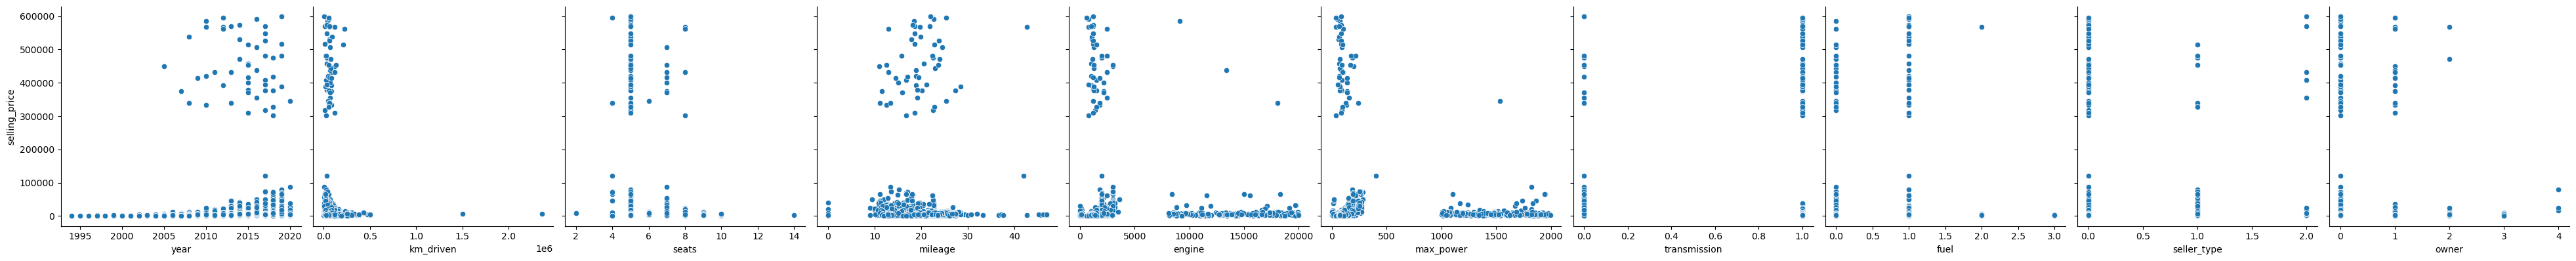

In [15]:
sns.pairplot(df_vehiculos_t, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

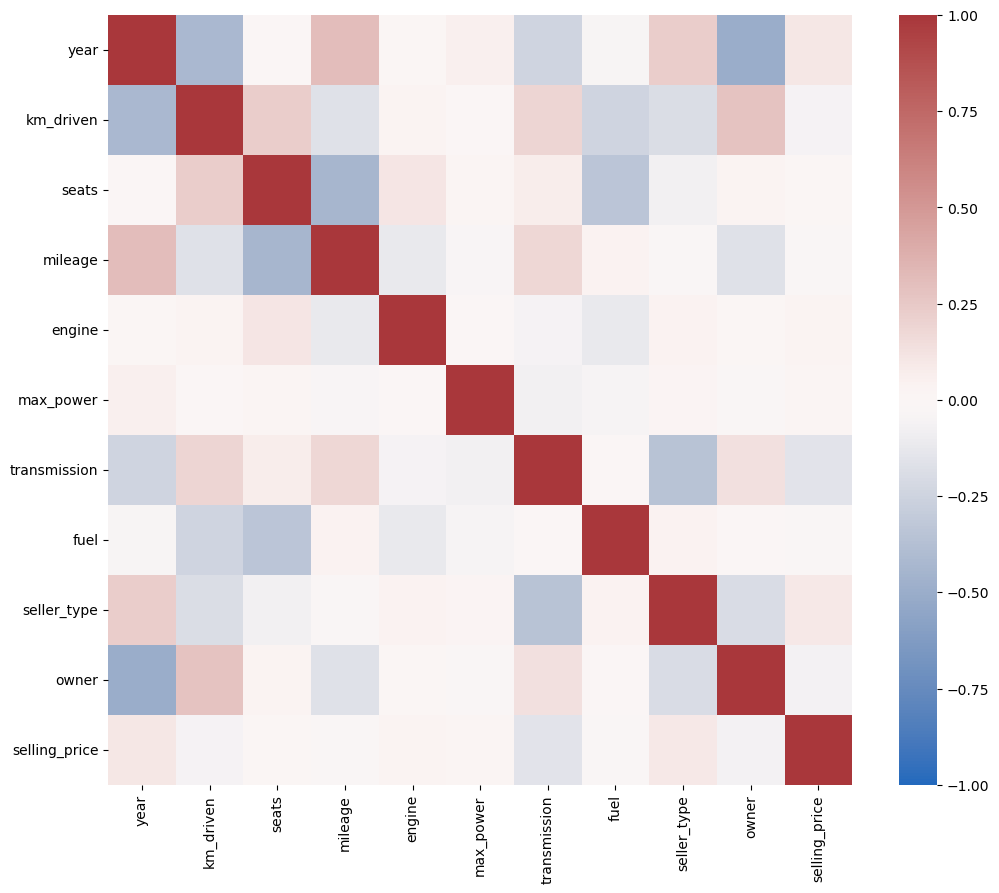

In [16]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_vehiculos_t[variables_interes+['selling_price']].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
plt.show()

Cambio de los valores nulos por la media de los datos por cada columna

In [17]:
df_vehiculos_copy = df_vehiculos_t.copy()

In [18]:
def fill_na_all(df, var_to_transform):
    for i in var_to_transform:
        mean = df[i].mean()
        df[i]=df[i].fillna(mean)
    mean = df['selling_price'].mean()
    df['selling_price']=df['selling_price'].fillna(mean)
    return df
        

In [19]:
df_vehiculos_copy= fill_na_all(df_vehiculos_copy,variables_interes)

In [20]:
df_vehiculos_copy.sample(5)
df_vehiculos_copy[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_copy.shape[0]
#Se muestra que se ha pasado los nulos a valores promedio

selling_price    0.0
year             0.0
km_driven        0.0
seats            0.0
mileage          0.0
engine           0.0
max_power        0.0
transmission     0.0
fuel             0.0
seller_type      0.0
owner            0.0
dtype: float64

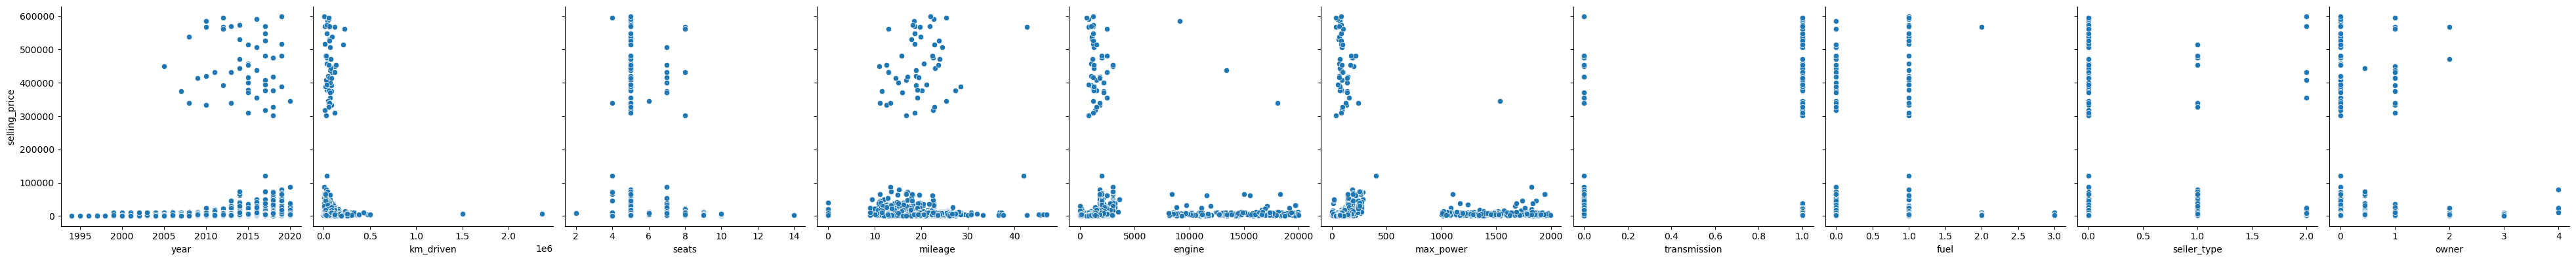

In [21]:
sns.pairplot(df_vehiculos_copy, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

## 3.Particionamiento del conjunto de datos.
Separación datos x y y para entrenamiento y x y y para test.

In [22]:
x_train, x_test, y_train,  y_test  = train_test_split(df_vehiculos_copy[variables_interes], df_vehiculos_copy['selling_price'], test_size=0.3, random_state=1)
x_train.shape, y_train.shape
x_test.shape, y_test.shape

((2135, 10), (2135,))

In [23]:
df_vehiculos_test_final = pd.read_csv('./data/MotorAlpes_test.csv', sep=',', encoding = 'utf-8')
X_test = df_vehiculos_test_final[variables_interes]
X_test.shape

(791, 10)

## 4. Entrenamiento de un primer modelo
Para este primer modelo solo se va a remplazar los valores nulos a la media  de todos los datos.

In [24]:
regression = LinearRegression()
regression.fit(x_train, y_train)

LinearRegression()

### 4.1 Interpretación de los coeficientes y del intercepto

En base a los coeficientes anteriormente mostrados, solo datos como engine, max_power, y km_driven tienen un coeficiente de puridad acceptablle .

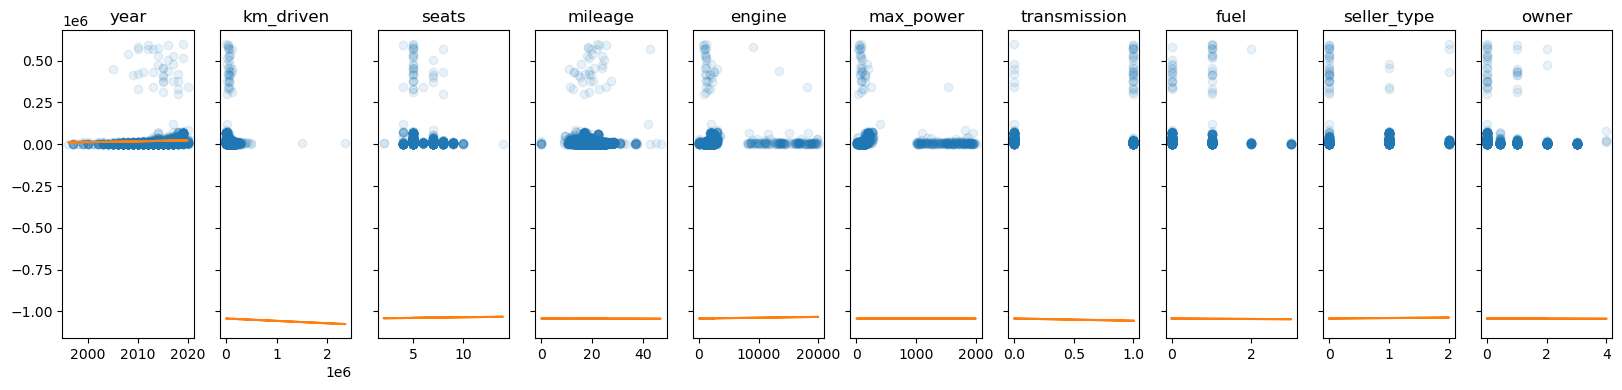

In [25]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [26]:
pd.DataFrame({'columns': variables_interes, 'coef': regression.coef_})

,columns,coef
0,year,527.723004
1,km_driven,-0.014191
2,seats,757.410616
3,mileage,-24.502906
4,engine,0.491141
5,max_power,-0.080101
6,transmission,-13324.571468
7,fuel,-1374.690842
8,seller_type,2895.432017
9,owner,-341.591025


In [27]:
regression.intercept_

-1043310.7831691629

De lo anterior se puede interpretar que hay mukchos valores atipicos que no permiten detectar una relación lineal entre el precio y alguna de las caracteristicas.

## 4.2 Validación del modelo
### Mean Absolute Error


In [28]:
print('Train:', mean_absolute_error(y_train, regression.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression.predict(x_test)))

Train: 8623.196191499303
Test: 8693.039622440407


### Root Mean Squeared Error (RMSE)

In [29]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(x_test))))

Train: 39318.06105227872
Test: 38240.213758734564


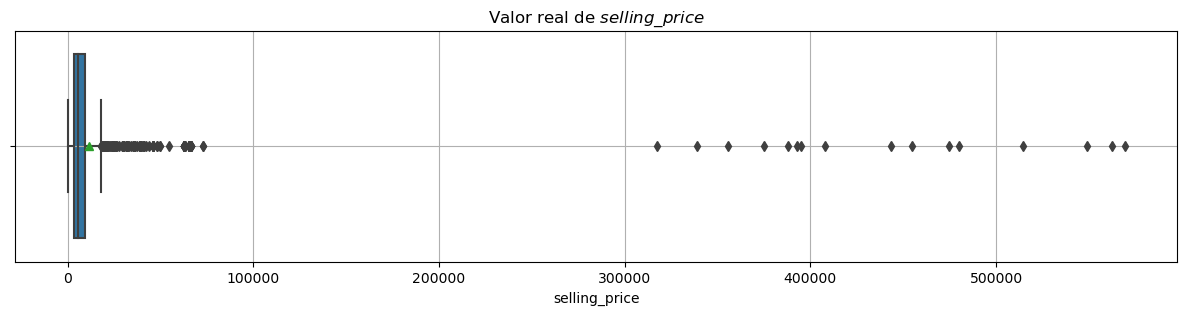

In [30]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 5. Entrenamiento 2do Modelo


In [60]:
def fill_outliers(df, var_to_transform):    
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df
        
 

In [61]:
df_vehiculos_transformed=fill_outliers(df_vehiculos_copy,variables_interes)

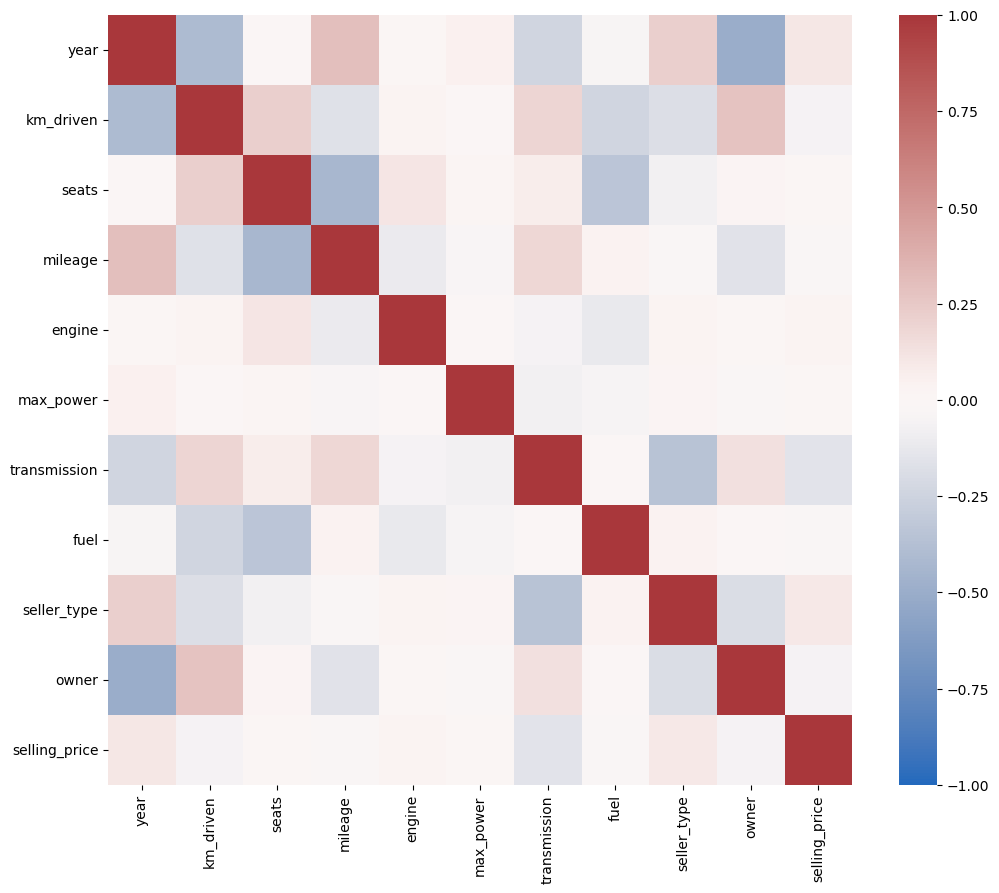

In [62]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_vehiculos_transformed[variables_interes+['selling_price']].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
plt.show()

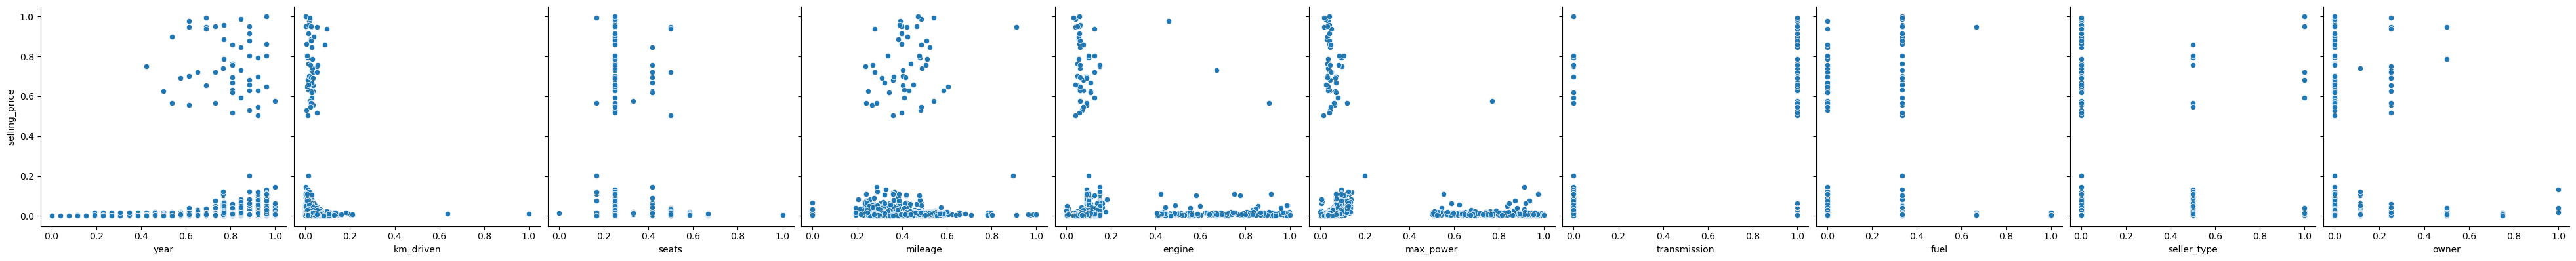

In [63]:
sns.pairplot(df_vehiculos_transformed, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

In [64]:
regression_2 = LinearRegression()
regression_2.fit(x_train, y_train)

LinearRegression()

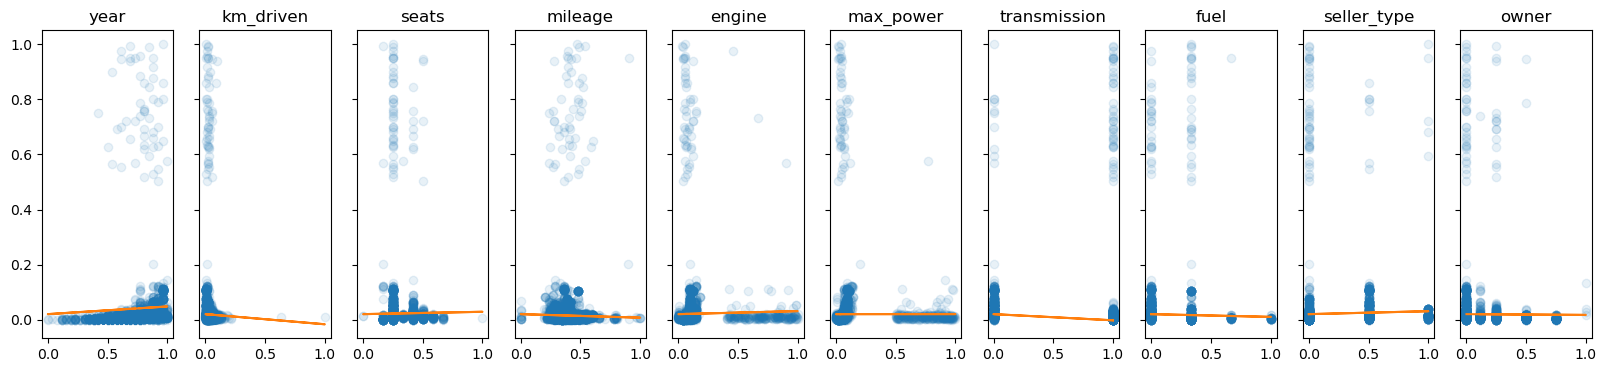

In [65]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_2.coef_[i]
    b = regression_2.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [66]:
regression_2.intercept_

0.0205197725491539

In [67]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_2.coef_})

,columns,coef
0,year,0.027848
1,km_driven,-0.036770
2,seats,0.008587
3,mileage,-0.012775
4,engine,0.011106
5,max_power,0.000177
6,transmission,-0.022354
7,fuel,-0.009954
8,seller_type,0.010679
9,owner,-0.002839


### 5.2 Validación 2do Modelo


#### Mean Absolute Error


In [68]:
print('Train:', mean_absolute_error(y_train, regression_2.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression_2.predict(x_test)))

Train: 0.014310331498308406
Test: 13708.908130876645


In [69]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression_2.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression_2.predict(x_test))))

Train: 0.06509475378775953
Test: 41270.24133782047


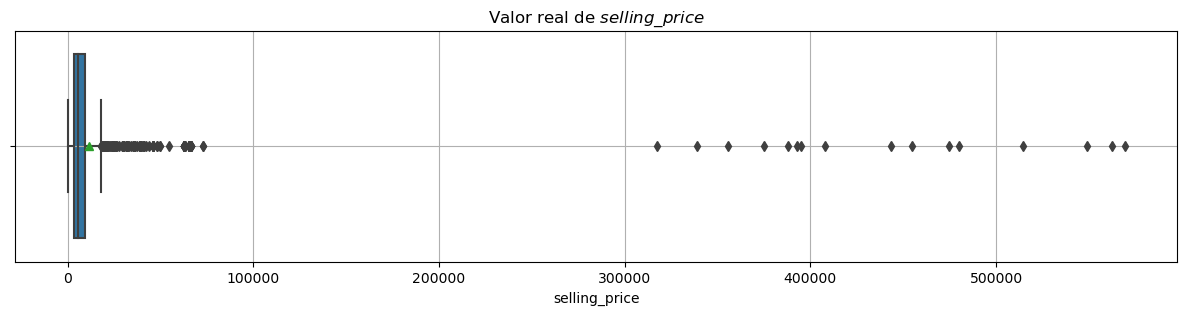

In [70]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 6. Entrenamiento 3er Modelo
Para este tercer modelo se plantea usar metodos de normalización con tal de llegar a quitar el efecto de los valores atipicos del modelo.

In [71]:
data_tercer_modelo = df_vehiculos_copy.copy()
def normalize_cols(df, var_to_transform):
    scaler = MinMaxScaler()

    arr_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)

    return df_scaled

        

In [72]:
norm_data=normalize_cols(data_tercer_modelo,variables_interes)
norm_data.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
5621,0.790575,0.769231,0.025418,0.00,0.0,0.25,0.333333,1.0,0.403708,0.059746,0.040575,0.007582
5630,0.791805,0.769231,0.025418,0.00,0.0,0.25,0.000000,1.0,0.534219,0.074820,0.044461,0.008593
1961,0.275132,0.769231,0.019064,0.00,0.0,0.25,0.000000,1.0,0.407980,0.584685,0.034559,0.008087
3507,0.494647,0.730769,0.025418,0.00,0.0,0.50,0.000000,1.0,0.257391,0.108924,0.059627,0.012133
5090,0.716993,0.615385,0.038551,0.25,0.0,0.25,0.333333,1.0,0.363124,0.074770,0.058624,0.006267


In [73]:
x_train, y_train  = norm_data[variables_interes], df_vehiculos_transformed['selling_price']
x_train.shape, y_train.shape

((7115, 10), (7115,))

In [74]:
regression_3 = LinearRegression()
regression_3.fit(x_train, y_train)
regression_3.intercept_

0.0205197725491539

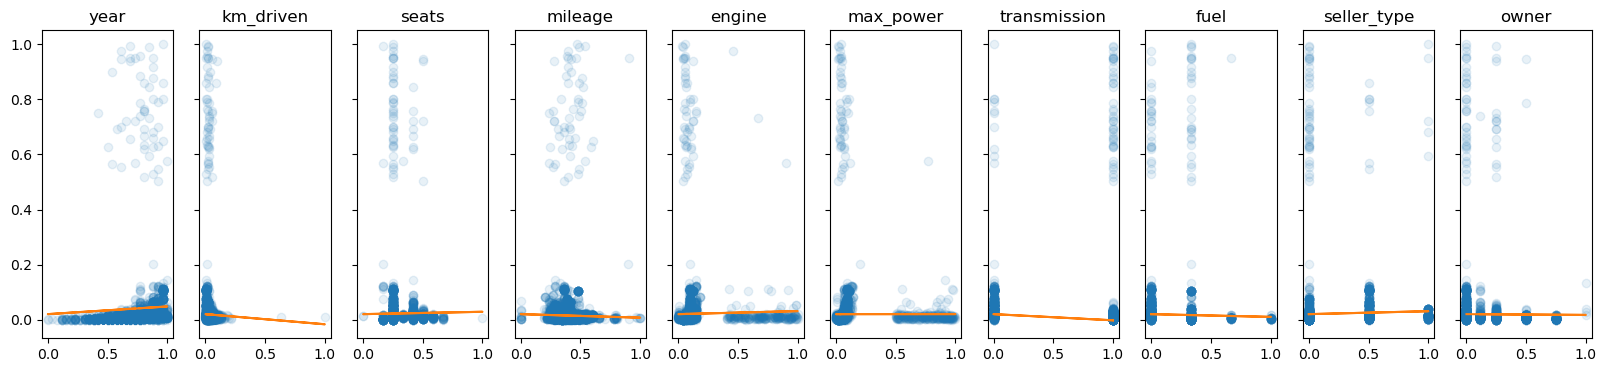

In [75]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_3.coef_[i]
    b = regression_3.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [46]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_3.coef_})

,columns,coef
0,year,0.027848
1,km_driven,-0.036770
2,seats,0.008587
3,mileage,-0.012775
4,engine,0.011106
5,max_power,0.000177
6,transmission,-0.022354
7,fuel,-0.009954
8,seller_type,0.010679
9,owner,-0.002839


### 5.2 Validación 2do Modelo


#### Mean Absolute Error

In [47]:
print('Train:', mean_absolute_error(y_train, regression_2.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression_2.predict(x_test)))

Train: 1054212.5908239614
Test: 8693.039622440407


In [48]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression_2.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression_2.predict(x_test))))

Train: 1054223.705232411
Test: 38240.213758734564


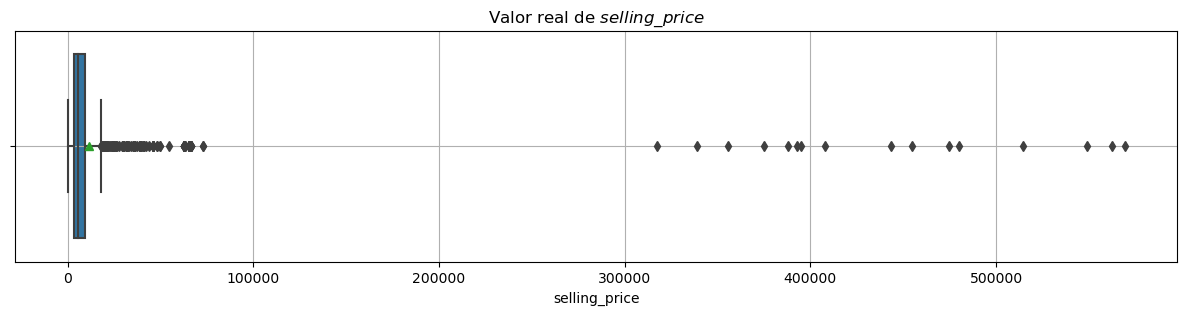

In [49]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 7.Entrenamiento 4to Modelo 

In [50]:
data_cuarto_modelo = df_vehiculos_copy.copy()
def scale_data(df):
    ss = StandardScaler()
    df_scaled = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
    return df_scaled

    


In [51]:
norm_data=normalize_cols(data_cuarto_modelo,variables_interes)
norm_data.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
3041,0.427956,0.653846,0.033891,0.25,0.0,0.250000,0.333333,1.0,0.434894,0.059746,0.039021,0.018797
1517,0.213855,0.576923,0.033891,0.50,0.0,0.416667,0.000000,1.0,0.257391,0.108924,0.059627,0.006469
6749,0.949305,0.961538,0.001482,0.00,0.5,0.250000,0.333333,0.0,0.387688,0.049780,0.058800,0.022752
1617,0.227513,0.846154,0.027537,0.00,0.0,0.250000,0.333333,1.0,0.380212,0.074770,0.058273,0.015632
5568,0.782946,0.884615,0.018640,0.00,0.5,0.250000,0.000000,1.0,0.505169,0.062300,0.610783,0.013144


In [52]:
regression_4 = LinearRegression()
regression_4.fit(x_train, y_train)
regression_4.intercept_

0.0205197725491539

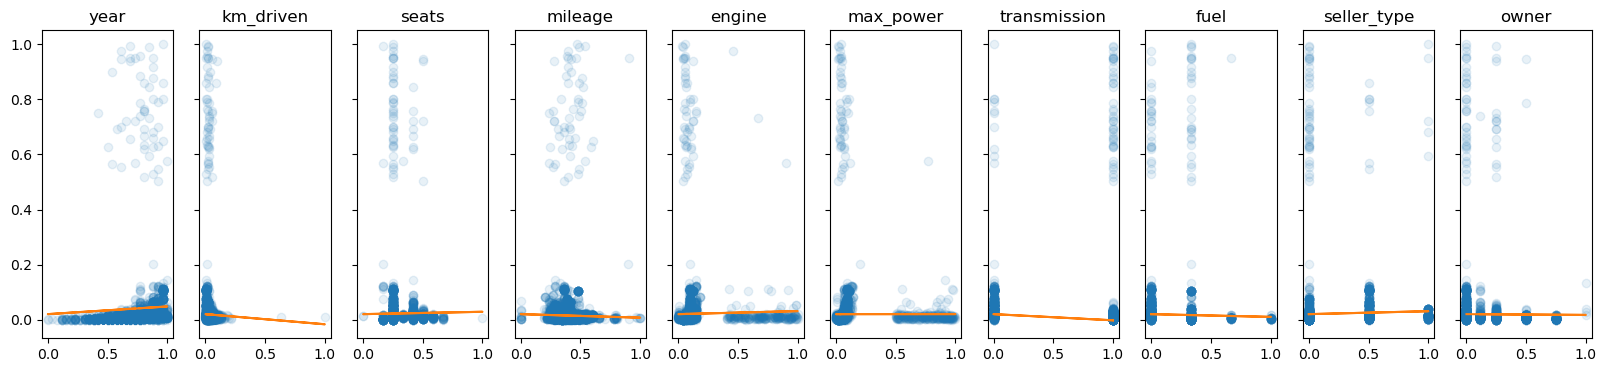

In [53]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_3.coef_[i]
    b = regression_3.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [54]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_3.coef_})

,columns,coef
0,year,0.027848
1,km_driven,-0.036770
2,seats,0.008587
3,mileage,-0.012775
4,engine,0.011106
5,max_power,0.000177
6,transmission,-0.022354
7,fuel,-0.009954
8,seller_type,0.010679
9,owner,-0.002839


## 7. Entrenamiento 4to Modelo

Para este segundo modelo se va a aplicar metodos de normalización con tal 

In [55]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [56]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [57]:
pd.DataFrame({'columns': variables_interes, 'coef': pipeline['model'].coef_})

,columns,coef
0,year,0.004056
1,km_driven,-0.000890
2,seats,0.000682
3,mileage,-0.001141
4,engine,0.001289
5,max_power,0.000024
6,transmission,-0.007597
7,fuel,-0.001786
8,seller_type,0.002517
9,owner,-0.000495


In [58]:
pipeline['model'].intercept_

0.01879740438975809